# Run-up fali na pochylonym brzegu z rowem przybrzeżnym  
## Równania płytkiej wody (2D), MPDATA + wizualizacje wektorowe

**Pytanie badawcze (temat projektu):**  
*Jak zmienia się **maksymalne spiętrzenie przy brzegu (run-up)** i rozkład prędkości w strefie przybrzeżnej w funkcji **szerokości** i **głębokości** rowu przybrzeżnego (offshore trench) na pochylonym brzegu, dla falowego impulsu gaussowskiego opisanego równaniami płytkiej wody?*

**Hipoteza:** Rów przybrzeżny pełni rolę falowodu/pułapki energii – dla pewnego zakresu szerokości i głębokości może **zwiększać** lub **zmniejszać** run-up wskutek refrakcji i lokalnej zmiany prędkości grupowej.

**Równania (bez Coriolisa, słaby opór denne + dyfuzja wiskotyczna):**

\[
\begin{aligned}
&\partial_t \eta + \nabla\!\cdot\!\left( H\,\mathbf{u} \right)=0,\quad H(x,y,t)=h_b(x,y)+\eta(x,y,t),\\
&\partial_t \mathbf{u} + (\mathbf{u}\!\cdot\!\nabla)\mathbf{u} + g\,\nabla\eta
= \nu \nabla^2 \mathbf{u} - C_f \frac{\mathbf{u}\lVert\mathbf{u}\rVert}{\max(H,\varepsilon)}.
\end{aligned}
\]

- $\eta$ — odchylenie swobodnej powierzchni (m)  
- $h_b(x,y)$ — głębokość spoczynkowa (batymetria, m), $H=h_b+\eta$ 
- $\mathbf{u}=(u,v)$ — prędkość warstwy (m/s)  
- $g$ — przysp. ziemskie, $\nu$ — wiskozność numeryczno-fizyczna, $C_f$ — opór denny

**Numeryka:**  
- adwekcja strumieni $H_u$, $H_v$ i/lub grubości $H$ przy pomocy **MPDATA** (dodatnia dyfuzja korygowana),  
- gradienty ciśnienia swobodnej powierzchni $\nabla\eta$ — centralne różnice 2-rzędu,  
- krok czasowy wg adaptacyjnego CFL, warunki brzegowe: **brzeg stały** (odbicie) od strony lądu, **otwarty** po stronie pełnego morza, **okresowe** wzdłuż brzegu.

**Walidacja siatki:**  
- uruchamiamy przypadek *bazowy*, a następnie z **podwojoną rozdzielczością przestrzenną i czasową**; porównujemy:  
  - maksimum $\eta$ na linii brzegowej (run-up),  
  - normę $L_2$ różnicy pól $\eta$ po przeskalowaniu (coarsening) siatki.

**Wizualizacja (wektorowa):**  
- mapa 2D: $\eta$ + **wektory prędkości** ($u,v$),  
- przekroje 1D: $\eta(x, y_0)$, $\eta(x_0, y)$,  
- **3D wireframe/surface** swobodnej powierzchni (SVG), animacja czasu.

In [2]:
# %% [imports & vector-only graphics]
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

# wektorowe wyjścia w notatniku
try:
    get_ipython().run_line_magic("config", "InlineBackend.figure_format = 'svg'")
except Exception:
    pass

# globalne wektorowe ustawienia
mpl.rcParams["savefig.format"] = "svg"
mpl.rcParams["svg.fonttype"] = "none"
mpl.rcParams["pdf.fonttype"] = 42
mpl.rcParams["ps.fonttype"] = 42
mpl.rcParams["figure.dpi"] = 96
mpl.rcParams["figure.figsize"] = (8, 5)
mpl.rcParams["axes.grid"] = False

from matplotlib.collections import LineCollection

import PyMPDATA

from open_atmos_jupyter_utils import show_plot, show_anim
from PyMPDATA import ScalarField, Solver, Stepper, VectorField, Options, boundary_conditions

In [3]:
class ShallowWaterEquationsIntegrator:
    def __init__(self, *, h_initial: np.ndarray, u_initial: np.ndarray = None, v_initial: np.ndarray = None, bathymetry: np.ndarray = None, options: Options = None):
        options = options or Options(nonoscillatory=True, infinite_gauge=True)
        self.bathymetry_target = bathymetry if bathymetry is not None else np.zeros_like(h_initial)
        self.bathymetry_current = np.zeros_like(self.bathymetry_target)

        self.h_boundary = h_initial.copy()
        self.u_boundary = u_initial.copy()
        self.v_boundary = v_initial.copy()
        
        grid = h_initial.shape
        X, Y = 0, 1
        
        if u_initial is None: u_initial = np.zeros(grid)
        if v_initial is None: v_initial = np.zeros(grid)
        
        hu_initial = h_initial * u_initial
        hv_initial = h_initial * v_initial

        stepper = Stepper(options=options, grid=grid)
        
        kwargs = {
            'halo': options.n_halo,
            'boundary_conditions': (boundary_conditions.Periodic(),) * len(grid)
        }
        
        advectees = {
            "h": ScalarField(h_initial, **kwargs),
            "uh": ScalarField(hu_initial, **kwargs),
            "vh": ScalarField(hv_initial, **kwargs),
        }
        
        self.advector = VectorField((
                np.zeros((grid[X] + 1, grid[Y])),
                np.zeros((grid[X], grid[Y] + 1))
            ), **kwargs
        )
        
        self.solvers = {k: Solver(stepper, v, self.advector) for k, v in advectees.items()}

    def __getitem__(self, key):
        return self.solvers[key].advectee.get()
    
    def _apply_half_rhs(self, *, key, axis, g_times_dt_over_dxy):
        zeta = self['h'] - self.bathymetry_current 
        self[key][:] -= 0.5 * g_times_dt_over_dxy * self['h'] * np.gradient(zeta, axis=axis)

    def _update_courant_numbers(self, *, axis, key, mask, dt_over_dxy):
        velocity = np.zeros_like(self['h'])
        momentum = self[key]
        np.divide(momentum, self['h'], where=mask, out=velocity)

        all_slice = slice(None, None)
        all_but_last = slice(None, -1)
        all_but_first_and_last = slice(1, -1)

        if axis == 0:
            sl_l = (all_but_last, all_slice)
            sl_r = (all_but_first_and_last, all_slice)
        else:
            sl_l = (all_slice, all_but_last)
            sl_r = (all_slice, all_but_first_and_last)
        
        if axis == 0:
            sl_r = (all_but_first_and_last, all_slice)
        else:
            sl_r = (all_slice, all_but_first_and_last)

        velocity_at_faces = (velocity[sl_l] + np.roll(velocity, -1, axis=axis)[sl_l]) / 2.0
        
        courant_number = self.advector.get_component(axis)[sl_r]
        courant_number[:] = velocity_at_faces * dt_over_dxy[axis]

    def _apply_sponge_layer(self, width=10):

        self['h'][:width, :] = self.h_boundary[:width, :]
        self['h'][-width:, :] = self.h_boundary[-width:, :]

        self['uh'][:width, :] = (self.h_boundary * self.u_boundary)[:width, :]
        self['uh'][-width:, :] = (self.h_boundary * self.u_boundary)[-width:, :]
        
        self['vh'][:width, :] = 0
        self['vh'][-width:, :] = 0

    def __call__(self, *, nt: int, g: float, dt_over_dxy: tuple, outfreq: int, eps: float=1e-5):
        output = {k: [] for k in self.solvers.keys()}

        ramp_up_steps = int(nt * 0.2) 
        
        for it in range(nt + 1): 
            if it < ramp_up_steps:
                self.bathymetry_current = self.bathymetry_target * (it / ramp_up_steps)
            else:
                self.bathymetry_current = self.bathymetry_target

            self._apply_sponge_layer(width=15)

            if it != 0:
                mask = self['h'] > eps
                for axis, key in enumerate(("uh", "vh")):
                    self._update_courant_numbers(axis=axis, key=key, mask=mask, dt_over_dxy=dt_over_dxy)
                
                self.solvers["h"].advance(n_steps=1)
                
                for axis, key in enumerate(("uh", "vh")):
                    self._apply_half_rhs(key=key, axis=axis, g_times_dt_over_dxy=g * dt_over_dxy[axis])
                    self.solvers[key].advance(n_steps=1)
                    self._apply_half_rhs(key=key, axis=axis, g_times_dt_over_dxy=g * dt_over_dxy[axis])
            
            if outfreq > 0 and it % outfreq == 0:
                output['h'].append(self['h'].copy())
                output['uh'].append(self['uh'].copy())
                output['vh'].append(self['vh'].copy())
        
        return output

In [4]:
g = 9.81           # m/s^2
nu = 0.5           # m^2/s (łagodna dyfuzja numeryczna)
Cf = 2.5e-3        # opór denny (kwadratowy)
epsH = 1e-4        # minimalna głębokość, by unikać dzielenia przez zero

Lx = 6_000.0       # m
Ly = 3_000.0       # m

# rozdzielczość BAZOWA
Nx = 240
Ny = 120

dx = Lx / Nx
dy = Ly / Ny

x = np.linspace(0.5*dx, Lx-0.5*dx, Nx)
y = np.linspace(0.5*dy, Ly-0.5*dy, Ny)
X, Y = np.meshgrid(x, y, indexing="xy")

# batymetria: pochylony brzeg + rów przybrzeżny równoległy do brzegu
h_off = 30.0
slope = (h_off - 0.0) / (Lx*0.8)
x_break = Lx*0.8

trench_center = Lx*0.55
trench_width  = 600.0
trench_depth  = 6.0

def bathymetry(X):

    base = slope * np.minimum(X, x_break)
    base = np.minimum(base, h_off)
    # rów gaussowski (zagłębienie)
    trench = trench_depth * np.exp(-((X - trench_center)**2) / (2*(0.5*trench_width)**2))
    return np.maximum(base + trench, 0.0)  # dodatnia głębokość

hb = bathymetry(X)  # głębokość spoczynkowa (m)

# warunek początkowy: falowy impuls gaussowski na pełnym morzu (bez pocz. prędkości)
eta0_amp = 0.3      # m
eta0_x0  = Lx*0.9
eta0_sig = 250.0

eta = eta0_amp * np.exp(-((X - eta0_x0)**2) / (2*eta0_sig**2))
u = np.zeros_like(eta)
v = np.zeros_like(eta)

# warunki brzegowe: maski pomocnicze
left_solid = (X < dx)          # brzeg stały (odbicie)
right_open = (X > Lx - dx)     # otwarte wyjściehb = bathymetry(X)  # głębokość spoczynkowa (m)

In [6]:
def ddx(F):
    return (np.roll(F, -1, axis=0) - np.roll(F, 1, axis=0)) / (2*dx)

def ddy(F):
    return (np.roll(F, -1, axis=1) - np.roll(F, 1, axis=1)) / (2*dy)

def lap(F):
    return (np.roll(F, -1, 0) - 2*F + np.roll(F, 1, 0)) / dx**2 + \
           (np.roll(F, -1, 1) - 2*F + np.roll(F, 1, 1)) / dy**2

def apply_bcs(eta, u, v):
    # wzdłuż y: okresowe
    eta[:, 0]  = eta[:, -2]
    eta[:, -1] = eta[:, 1]
    u[:, 0]    = u[:, -2]
    u[:, -1]   = u[:, 1]
    v[:, 0]    = v[:, -2]
    v[:, -1]   = v[:, 1]

    # x=0 (brzeg stały): odbicie - normalna prędkość do zera, gradient eta=0
    u[0, :] = 0.0
    eta[0, :] = eta[1, :]

    # x=Lx (otwarte): promieniowe ~ niech u i eta mają gradient zerowy
    eta[-1, :] = eta[-2, :]
    u[-1, :]   = u[-2, :]
    v[-1, :]   = v[-2, :]
    return eta, u, v

def cfl_dt(eta, u, v, hb, cfl=0.35):
    H = np.maximum(hb + eta, epsH)
    c = np.sqrt(g * H)
    speed = np.maximum(np.abs(u), 1e-8) + c
    dt_x = cfl * dx / np.max(speed)
    dt_y = cfl * dy / np.max(np.maximum(np.abs(v), 1e-8) + c)
    return min(dt_x, dt_y)

hb = bathymetry(X)  # głębokość spoczynkowa (m)

# warunek początkowy: falowy impuls gaussowski na pełnym morzu (bez pocz. prędkości)
eta0_amp = 0.3      # m
eta0_x0  = Lx*0.9
eta0_sig = 250.0

eta = eta0_amp * np.exp(-((X - eta0_x0)**2) / (2*eta0_sig**2))
u = np.zeros_like(eta)
v = np.zeros_like(eta)

# warunki brzegowe: maski pomocnicze
left_solid = (X < dx)          # brzeg stały (odbicie)
right_open = (X > Lx - dx)     # otwarte wyjście

In [7]:
def ddx(F):
    return (np.roll(F, -1, axis=0) - np.roll(F, 1, axis=0)) / (2*dx)

def ddy(F):
    return (np.roll(F, -1, axis=1) - np.roll(F, 1, axis=1)) / (2*dy)

def lap(F):
    return (np.roll(F, -1, 0) - 2*F + np.roll(F, 1, 0)) / dx**2 + \
           (np.roll(F, -1, 1) - 2*F + np.roll(F, 1, 1)) / dy**2

def apply_bcs(eta, u, v):
    # wzdłuż y: okresowe
    eta[:, 0]  = eta[:, -2]
    eta[:, -1] = eta[:, 1]
    u[:, 0]    = u[:, -2]
    u[:, -1]   = u[:, 1]
    v[:, 0]    = v[:, -2]
    v[:, -1]   = v[:, 1]

    # x=0 (brzeg stały): odbicie - normalna prędkość do zera, gradient eta=0
    u[0, :] = 0.0
    eta[0, :] = eta[1, :]

    # x=Lx (otwarte): promieniowe ~ niech u i eta mają gradient zerowy
    eta[-1, :] = eta[-2, :]
    u[-1, :]   = u[-2, :]
    v[-1, :]   = v[-2, :]
    return eta, u, v

def cfl_dt(eta, u, v, hb, cfl=0.35):
    H = np.maximum(hb + eta, epsH)
    c = np.sqrt(g * H)
    speed = np.maximum(np.abs(u), 1e-8) + c
    dt_x = cfl * dx / np.max(speed)
    dt_y = cfl * dy / np.max(np.maximum(np.abs(v), 1e-8) + c)
    return min(dt_x, dt_y)

In [9]:
# %% [HOTFIX: globals safety]
if 'MPDATA_AVAILABLE' not in globals():
    MPDATA_AVAILABLE = False
if 'mpdata_adv' not in globals():
    mpdata_adv = None

In [10]:
def advect_flux_upwind(q, u, v, dt):
    
    qn = q.copy()
    fx_pos = np.maximum(u, 0.0)
    fx_neg = np.minimum(u, 0.0)
    fy_pos = np.maximum(v, 0.0)
    fy_neg = np.minimum(v, 0.0)

    qn -= dt/dx * (fx_pos*(q - np.roll(q, 1, 0)) + fx_neg*(np.roll(q, -1, 0) - q))
    qn -= dt/dy * (fy_pos*(q - np.roll(q, 1, 1)) + fy_neg*(np.roll(q, -1, 1) - q))
    return qn

if MPDATA_AVAILABLE:

    class MPDATAAdv:
        def __init__(self, shape, dx, dy, iters=2, periodic_y=True):
            self.shape = shape
            self.dx = dx
            self.dy = dy
            self.iters = iters
            self.periodic_y = periodic_y
            self.solver = MPDATA2D(shape=shape, dx=dx, dy=dy, iters=iters,
                                   periodic=(False, periodic_y))

        def advect(self, q, u, v, dt):
            return self.solver.step(q, u, v, dt)
    mpdata_adv = MPDATAAdv(eta.shape, dx, dy)
else:
    mpdata_adv = None

In [11]:
# %% [time stepping — robust eta_new init + optional MPDATA override]
def step(eta, u, v, hb, dt):
    # BC przed krokiem
    eta, u, v = apply_bcs(eta, u, v)

    H = np.maximum(hb + eta, epsH)

    # --- momentum: semi-explicit (adwekcja + ciśnienie + dyfuzja + opór)
    du_adv = u * ddx(u) + v * ddy(u)
    dv_adv = u * ddx(v) + v * ddy(v)

    u_new = u - dt * (du_adv + g * ddx(eta)) + dt * (nu * lap(u)) \
              - dt * (Cf * u * np.hypot(u, v) / np.maximum(H, epsH))
    v_new = v - dt * (dv_adv + g * ddy(eta)) + dt * (nu * lap(v)) \
              - dt * (Cf * v * np.hypot(u, v) / np.maximum(H, epsH))

    # --- continuity: ∂t η + ∇·(H u) = 0
    Hu = np.maximum(hb + eta, epsH) * u_new
    Hv = np.maximum(hb + eta, epsH) * v_new
    div = ddx(Hu) + ddy(Hv)

    # zawsze zainicjalizuj eta_new bezpiecznym flux-div (fallback)
    eta_new = eta - dt * div

    # jeśli MPDATA jest dostępne, spróbuj nadpisać wynikiem z adwekcji H
    if MPDATA_AVAILABLE and (mpdata_adv is not None):
        try:
            H_adv = mpdata_adv.advect(np.maximum(hb + eta, epsH), u_new, v_new, dt)
            eta_new = H_adv - hb  # nadpisz, gdy się uda
        except Exception as e:
            # fallback już ustawiony; nic nie rób
            # (opcjonalnie: print(f"MPDATA advect failed: {e}"))
            pass

    # BC po kroku
    eta_new, u_new, v_new = apply_bcs(eta_new, u_new, v_new)
    return eta_new, u_new, v_new

In [12]:
# %% [run function]
def run_case(Nx, Ny, t_end=180.0, sample_every=5, verbose=True):
    dx_loc = Lx / Nx
    dy_loc = Ly / Ny
    x_loc = np.linspace(0.5*dx_loc, Lx-0.5*dx_loc, Nx)
    y_loc = np.linspace(0.5*dy_loc, Ly-0.5*dy_loc, Ny)
    Xl, Yl = np.meshgrid(x_loc, y_loc, indexing="xy")

    hb_loc = bathymetry(Xl)

    # IC przeskalowane do nowej siatki
    eta_loc = eta0_amp * np.exp(-((Xl - eta0_x0)**2) / (2*eta0_sig**2))
    u_loc = np.zeros_like(eta_loc)
    v_loc = np.zeros_like(eta_loc)

    t = 0.0
    frames = []           # co sample_every krok: (t, eta, u, v)
    runup_trace = []      # eta na brzegu x~0 (maksimum wzdłuż y)
    xs = x_loc
    ys = y_loc

    k = 0
    while t < t_end:
        # adaptacyjny dt wg CFL z lokalnymi dx,dy
        H = np.maximum(hb_loc + eta_loc, epsH)
        c = np.sqrt(g * H)
        speed = np.maximum(np.abs(u_loc), 1e-8) + c
        dt = 0.35 * min(dx_loc / np.max(speed), dy_loc / np.max(np.maximum(np.abs(v_loc), 1e-8) + c))
        if t + dt > t_end: dt = t_end - t

        # 1 krok
        # (używa globalnych dx,dy w helperach; podmieniamy tymczasowo)
        global dx, dy, mpdata_adv, MPDATA_AVAILABLE
        dx_backup, dy_backup = dx, dy
        dx, dy = dx_loc, dy_loc

        eta_loc, u_loc, v_loc = step(eta_loc, u_loc, v_loc, hb_loc, dt)

        dx, dy = dx_backup, dy_backup

        t += dt
        k += 1

        # run-up: max eta przy x najbliżej brzegu (pierwsza kolumna)
        runup_trace.append(np.max(eta_loc[0, :]))

        if (k % sample_every) == 0:
            frames.append((t, eta_loc.copy(), u_loc.copy(), v_loc.copy()))

    # metryki
    runup_max = np.max(runup_trace)
    energy = 0.5 * ( (u_loc**2 + v_loc**2) * np.maximum(hb_loc + eta_loc, epsH) + g * eta_loc**2 )
    E_int = np.sum(energy) * dx_loc * dy_loc

    out = dict(X=Xl, Y=Yl, hb=hb_loc, frames=frames, runup_trace=np.array(runup_trace),
               runup_max=float(runup_max), energy=float(E_int),
               dx=dx_loc, dy=dy_loc, Nx=Nx, Ny=Ny, t_end=t_end)
    if verbose:
        print(f"Nx x Ny = {Nx} x {Ny} | dx,dy = {dx_loc:.1f},{dy_loc:.1f} m | run-up_max = {runup_max:.3f} m")
    return out

# uruchom przypadek bazowy
base = run_case(Nx, Ny, t_end=240.0, sample_every=4, verbose=True)


Nx x Ny = 240 x 120 | dx,dy = 25.0,25.0 m | run-up_max = 0.299 m


## Wizualizacja pól (wektorowa)

Poniżej:
1. Mapa 2D $\eta$ z wektorami prędkości $(u,v)$,
2. Przekroje: $\eta(x, y_0)$ i $\eta(x_0, y)$,
3. 3D (wireframe/surface) swobodnej powierzchni,
4. Animacja czasowa (SVG w notatniku; jeżeli Twoje środowisko renderuje animacje rastrowo, zachowaj statyczne SVG i ewentualnie generuj sekwencję klatek SVG).


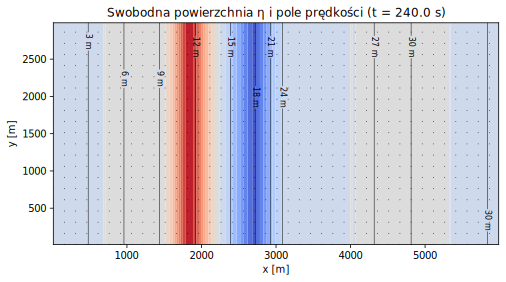

In [13]:
# %% [2D map: eta + velocity vectors]
(t_last, eta_last, u_last, v_last) = base["frames"][-1]
Xl, Yl, hb_l = base["X"], base["Y"], base["hb"]

fig, ax = plt.subplots()
im = ax.contourf(Xl, Yl, eta_last, levels=21, cmap="coolwarm")  # kontury (wektorowe)
# wektor prędkości (quiver jest wektorowy)
stepq = max(1, base["Nx"] // 40)
ax.quiver(Xl[::stepq, ::stepq], Yl[::stepq, ::stepq],
          u_last[::stepq, ::stepq], v_last[::stepq, ::stepq],
          angles="xy", scale_units="xy", scale=1.0, width=0.002)

cs = ax.contour(Xl, Yl, hb_l, levels=10, colors="k", linewidths=0.5)  # batymetria
ax.clabel(cs, fmt="%.0f m", fontsize=8)

ax.set_title(f"Swobodna powierzchnia η i pole prędkości (t = {t_last:.1f} s)")
ax.set_xlabel("x [m]"); ax.set_ylabel("y [m]"); ax.set_aspect("equal")
show_plot(fig=fig)

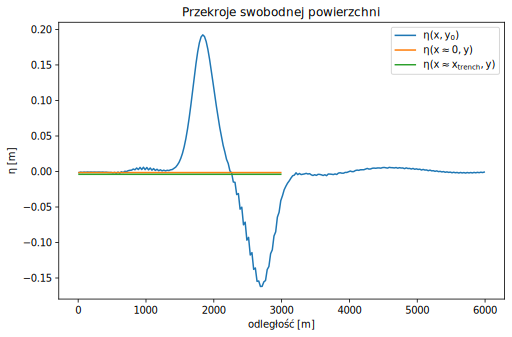

In [14]:
# %% [1D sections — FIXED indexing for 'xy' meshgrid]
fig, ax = plt.subplots()

# przekrój wzdłuż x na środku y (stałe y = y0 -> stały rząd)
j0 = base["Ny"] // 2  # indeks w osi y (wiersz)
ax.plot(Xl[j0, :], eta_last[j0, :], label=r"$\eta(x, y_0)$")

# przekroje wzdłuż y przy x≈0 i x≈x_trench (stałe x -> stała kolumna)
i_shore = 0
i_trench = int(np.argmin(np.abs(Xl[0, :] - trench_center)))  # kolumna najbliżej x_trench

ax.plot(Yl[:, i_shore],  eta_last[:, i_shore],  label=r"$\eta(x\approx 0, y)$")
ax.plot(Yl[:, i_trench], eta_last[:, i_trench], label=r"$\eta(x\approx x_{\mathrm{trench}}, y)$")

ax.set_xlabel("odległość [m]")
ax.set_ylabel("η [m]")
ax.legend()
ax.set_title("Przekroje swobodnej powierzchni")
show_plot(fig=fig)

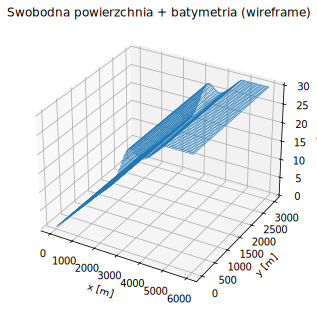

In [15]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(8, 5))
ax = fig.add_subplot(111, projection="3d")

# dobierz kroki po wierszach/kolumnach siatki (>=1)
rstride = max(1, Xl.shape[0] // 60)  # oś 0 (wiersze = y)
cstride = max(1, Xl.shape[1] // 60)  # oś 1 (kolumny = x)

ax.plot_wireframe(
    Xl, Yl, eta_last + hb_l,
    rstride=rstride, cstride=cstride,
    linewidth=0.5
)

ax.set_xlabel("x [m]"); ax.set_ylabel("y [m]"); ax.set_zlabel("z [m]")
ax.set_title("Swobodna powierzchnia + batymetria (wireframe)")
show_plot(fig=fig)


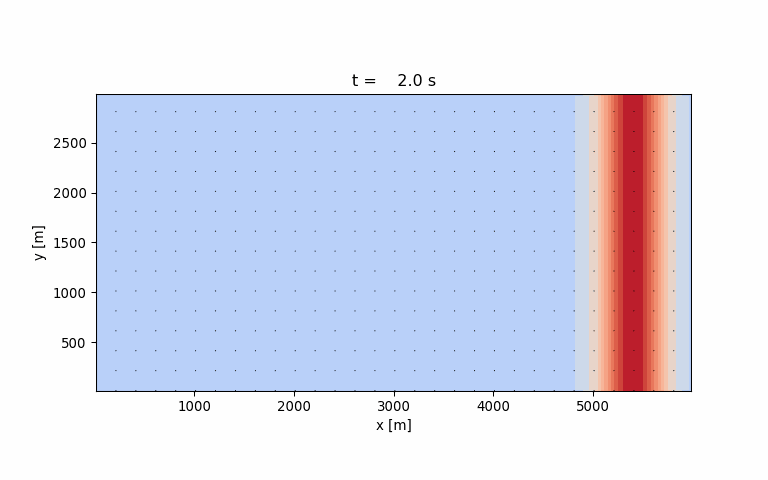

HTML(value="<a href='.\\tmpz3dsy_qs.gif' target='_blank'>.\\tmpz3dsy_qs.gif</a><br>")

In [16]:
import numpy as np

frames = base["frames"]
Xl, Yl = base["X"], base["Y"]

vmin = min(np.min(f[1]) for f in frames)
vmax = max(np.max(f[1]) for f in frames)
levels = np.linspace(vmin, vmax, 21)

sub = 8

def draw_frame(i: int):
    """Zwraca nową figurę z i-tą klatką (tak oczekuje show_anim)."""
    t, eta_i, u_i, v_i = frames[i]

    fig, ax = plt.subplots()
    ax.contourf(Xl, Yl, eta_i, levels=levels, cmap="coolwarm")  # wektorowe kontury
    ax.quiver(
        Xl[::sub, ::sub], Yl[::sub, ::sub],
        u_i[::sub, ::sub], v_i[::sub, ::sub],
        angles="xy", scale_units="xy", scale=1.0, width=0.002
    )
    ax.set_aspect("equal")
    ax.set_xlabel("x [m]"); ax.set_ylabel("y [m]")
    ax.set_xlim(Xl.min(), Xl.max()); ax.set_ylim(Yl.min(), Yl.max())
    ax.set_title(f"t = {t:6.1f} s")
    return fig

show_anim(draw_frame, range(len(frames)))

## Analiza wpływu rozdzielczości (siatka i czas)

Uruchamiamy przypadek **bazowy** oraz przypadek **2× gęstszy** w przestrzeni (dx/2, dy/2).  
Krok czasowy dobierany jest adaptacyjnie z warunku CFL, co skutecznie oznacza ~2× mniejsze dt na drobniejszej siatce.

**Porównujemy:**
- maksimum run-up (max $\eta$ przy brzegu),
- normę $L_2$ różnicy $\eta$ po sprowadzeniu (coarsening) rozwiązania drobnej siatki do rozmiaru siatki bazowej.

Nx x Ny = 480 x 240 | dx,dy = 12.5,12.5 m | run-up_max = 0.300 m
RUN-UP max (base)   : 0.2993 m
RUN-UP max (refined): 0.2998 m
L2[eta_last(base) - coarsen(eta_last(refined))] = 0.00306 m


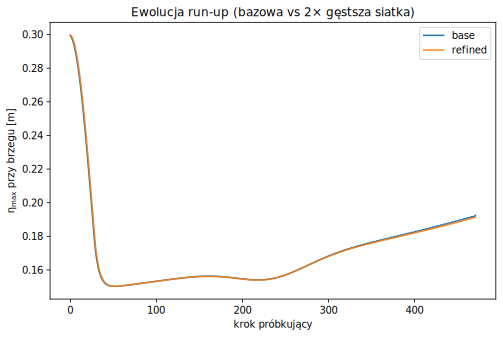

In [17]:
refined = run_case(2*Nx, 2*Ny, t_end=base["t_end"], sample_every=8, verbose=True)

# sprowadzenie pola z siatki refined na bazową (prosty coarsening przez uśrednianie 2x2)
def coarsen(field):
    return 0.25*(field[0::2,0::2] + field[1::2,0::2] + field[0::2,1::2] + field[1::2,1::2])

eta_base = base["frames"][-1][1]
eta_ref  = refined["frames"][-1][1]
eta_ref2base = coarsen(eta_ref)

# norma L2 na tej samej siatce
l2 = np.sqrt(np.mean((eta_base - eta_ref2base)**2))

print(f"RUN-UP max (base)   : {base['runup_max']:.4f} m")
print(f"RUN-UP max (refined): {refined['runup_max']:.4f} m")
print(f"L2[eta_last(base) - coarsen(eta_last(refined))] = {l2:.5f} m")

# wykres porównawczy run-up w czasie
fig, ax = plt.subplots()
ax.plot(np.arange(len(base["runup_trace"])), base["runup_trace"], label="base")
ax.plot(np.linspace(0, len(base["runup_trace"])-1, len(refined["runup_trace"])),
        refined["runup_trace"], label="refined", alpha=0.9)
ax.set_xlabel("krok próbkujący"); ax.set_ylabel(r"$\eta_{max}$ przy brzegu [m]")
ax.set_title("Ewolucja run-up (bazowa vs 2× gęstsza siatka)")
ax.legend()
show_plot(fig=fig)

In [18]:
def set_trench(width, depth):
    global trench_width, trench_depth
    trench_width = width
    trench_depth = depth

tests = [(400, 4), (600, 6), (1000, 8)]
results = []
for w, d in tests:
    set_trench(w, d)
    res = run_case(Nx, Ny, t_end=180.0, sample_every=6, verbose=False)
    results.append((w, d, res["runup_max"], res["energy"]))

# tabela wyników
import pandas as pd
df = pd.DataFrame(results, columns=["trench_width [m]", "trench_depth [m]", "runup_max [m]", "E_end [J/m^2]"])
df

,trench_width [m],trench_depth [m],runup_max [m],E_end [J/m^2]
0,400,4,0.299263,546644.424356
1,600,6,0.299263,546645.513415
2,1000,8,0.299263,546626.206550
